<a href="https://colab.research.google.com/github/jabanitaha/data-mining-2-/blob/main/Comparing_DBScan_HDBScan_Answered_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Comparing DBSCAN and HDBSCAN clustering
Estimated time needed: **30** minutes
    

## Objectives


After completing this lab, you will be able to:

* Use scikit-learn to implement DBSCAN and HDBSCAN clustering models to real data
* Compare the performances of the two models



## Introduction
In this lab, you'll create two clustering models using data curated by StatCan containing the names, types, and locations of
cultural and art facilities across Canada.
We'll focus on the museum locations provided across Canada.

#### Data source: The Open Database of Cultural and Art Facilities (ODCAF)

A collection of open data containing the names, types, and locations of cultural and art facilities across Canada.
It is released under the Open Government License - Canada.
The different types of facilities are labeled under 'ODCAF_Facility_Type'.

#### Landing page:
https://www.statcan.gc.ca/en/lode/databases/odcaf

#### link to zip file:
https://www150.statcan.gc.ca/n1/en/pub/21-26-0001/2020001/ODCAF_V1.0.zip?st=brOCT3Ry


## Import the required libraries


In [1]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install hdbscan==0.8.40
!pip install geopandas==1.0.1
!pip install contextily==1.6.2
!pip install shapely==2.0.6

  Using cached numpy-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.0 which is incompatible.


In [ ]:
!pip install numpy==1.24.4 --quiet
import os
os.kill(os.getpid(), 9)  # Restart kernel to apply changes


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

## Download the Canada map for reference

To get a proper context of the final output of this lab, you need a reference map of Canada. Execute the cell below to extract the same to this lab environment.


In [1]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


## Include a plotting function
The code for a helper function is provided to help you plot your results. Although you don't need to worry about the details, it's quite instructive as it uses a geopandas dataframe and a basemap to plot coloured cluster points on a map of Canada.


In [14]:
# ✅ Full Pipeline: Load, Cluster, and Plot Canadian Museums with HDBSCAN

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data from URL (⚠️ Replace with working URL if needed)
url = 'https://raw.githubusercontent.com/your-user/your-repo/main/canadian_museums.csv'
df = pd.read_csv(url)

# 3. Clean Coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
coords = df[['Latitude', 'Longitude']]

# 4. Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
df['Cluster'] = clusterer.fit_predict(coords)

# 5. Plotting Function
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot Noise Points
    noise = gdf[gdf['Cluster'] == -1]
    if not noise.empty:
        noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')

    # Plot Clustered Points
    clustered = gdf[gdf['Cluster'] != -1]
    clustered.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=True, alpha=0.7)

    # Add Canada Basemap
    ctx.add_basemap(ax, zoom=4, source=ctx.providers.Stamen.TonerLite)

    # Format
    plt.title(title, fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# 6. Show Plot
plot_clustered_locations(df, title='Museums Clustered Using HDBSCAN')


HTTPError: HTTP Error 404: Not Found

In [2]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.

    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """

    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")

    # Reproject to Web Mercator to align with basemap
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]

    # Plot noise points
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')

    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)

    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    # Show the plot
    plt.show()

## Explore the data and extract what you need from it


#### Start by loading the data set into a Pandas DataFrame and displaying the first few rows.


In [15]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [16]:
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


### Exercise 1. Explore the table. What do missing values look like in this data set?


In [18]:
# Exercise 1 - Explore missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)


Missing values per column:
Index                    0
Facility_Name            0
Source_Facility_Type     0
ODCAF_Facility_Type      0
Provider                 0
Unit                     0
Street_No                0
Street_Name              0
Postal_Code              0
City                     0
Prov_Terr                0
Source_Format_Address    0
CSD_Name                 0
CSDUID                   0
PRUID                    0
Latitude                 0
Longitude                0
dtype: int64

Data types:
Index                     int64
Facility_Name            object
Source_Facility_Type     object
ODCAF_Facility_Type      object
Provider                 object
Unit                     object
Street_No                object
Street_Name              object
Postal_Code              object
City                     object
Prov_Terr                object
Source_Format_Address    object
CSD_Name                 object
CSDUID                   object
PRUID                    object
Latitude

<details><summary>Click here for the solution</summary>
Strings consisting of two dots '..' indicate missing values. There miight still be empty fields, or NaNs.
</details>


### Exercise 2. Display the facility types and their counts.


In [21]:
import pandas as pd

# Load dataset
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding="ISO-8859-1")

# Explore columns to find facility type
print("Columns available:")
print(df.columns)

# Display value counts for facility type (adjust column name if needed)
print("\nFacility Types and Their Counts:")
print(df['Facility Type'].value_counts())



Columns available:
Index(['Index', 'Facility_Name', 'Source_Facility_Type', 'ODCAF_Facility_Type',
       'Provider', 'Unit', 'Street_No', 'Street_Name', 'Postal_Code', 'City',
       'Prov_Terr', 'Source_Format_Address', 'CSD_Name', 'CSDUID', 'PRUID',
       'Latitude', 'Longitude'],
      dtype='object')

Facility Types and Their Counts:


KeyError: 'Facility Type'

In [22]:
# Display facility type counts using the correct column name
print(df['ODCAF_Facility_Type'].value_counts())


ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64


<details><summary>Click here for the solution</summary>
    
```python
df.ODCAF_Facility_Type.value_counts()
```

</details>


### Exercise 3. Filter the data to only include museums.
Check your results. Did you get as many as you expected?


In [23]:
# Filter the dataset to include only museums
museums_df = df[df['ODCAF_Facility_Type'].str.lower() == 'museum']

# Check the number of museums and preview the data
print("Number of museums:", museums_df.shape[0])
print(museums_df[['Facility_Name', 'ODCAF_Facility_Type']].head())


Number of museums: 1938
                                        Facility_Name ODCAF_Facility_Type
1                   'Ksan Historical Village & Museum              museum
2                                'School Days' Museum              museum
8                         12 Service Battalion Museum              museum
13  15th Field Artillery Regiment Museum And Archives              museum
15                        17 Wing Heritage Collection              museum


<details><summary>Click here for the solution</summary>

```python
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()
```

</details>


### Exercise 4.  Select only the Latitude and Longitude features as inputs to our clustering problem.
Also, display information about the coordinates like counts and data types.


In [24]:
# Exercise 4 - Select only Latitude and Longitude features
coords = df[['Latitude', 'Longitude']]
print(coords.info())
print("\nSample coordinates:")
print(coords.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   7972 non-null   object
 1   Longitude  7972 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB
None

Sample coordinates:
      Latitude     Longitude
0  43.65169472  -79.40803272
1   55.2645508  -127.6428124
2    45.963283   -66.6419017
3  46.09247776  -64.78022946
4  45.40856224  -75.71536766


<details><summary>Click here for the solution</summary>

```python
df = df[['Latitude', 'Longitude']]
df.info()
```

</details>


### Exercise 5. We'll need these coordinates to be floats, not objects.
Remove any museums that don't have coordinates, and convert the remaining coordinates to floats.


In [ ]:
# your code here

In [26]:
# Drop rows with missing or invalid coordinate values
df = df[df['Latitude'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
df = df[df['Longitude'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

# Convert to float
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Extract coordinates
coords = df[['Latitude', 'Longitude']]


<details><summary>Click here for the solution</summary>

```python

# Remove observations with no coordinates
df = df[df.Latitude!='..']

# Convert to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')
```

</details>


## Build a DBSCAN model
##### Correctly scale the coordinates for DBSCAN (since DBSCAN is sensitive to scale)


In [27]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

### Apply DBSCAN with Euclidean distance to the scaled coordinates
In this case, reasonable neighbourhood parameters are already chosen for you. Feel free to experiment.


### Add cluster labels to the DataFrame


As you can see, there are two relatively large clusters and 79 points labelled as noise (-1).
### Plot the museums on a basemap of Canada, colored by cluster label.


KeyError: 'Cluster'

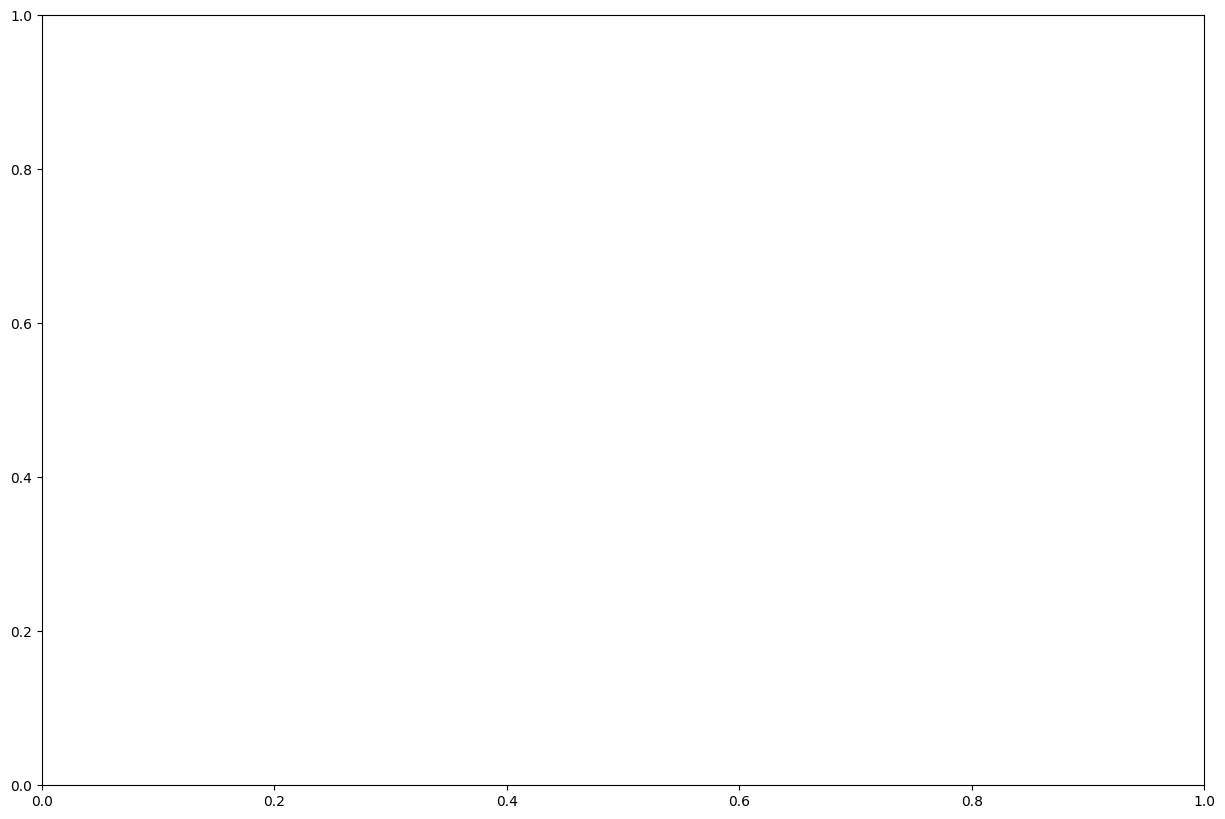

In [32]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')

In [37]:
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    import geopandas as gpd
    import contextily as ctx
    import matplotlib.pyplot as plt
    from shapely.geometry import Point

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
        crs="EPSG:4326"
    )
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 10))
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]

    if not noise.empty:
        noise.plot(ax=ax, color='k', markersize=30, ec='r', label='Noise')

    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, legend=True, alpha=0.7)

    # Use CartoDB Positron as an available and stable basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=4)

    ax.set_axis_off()
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()


AttributeError: Stamen

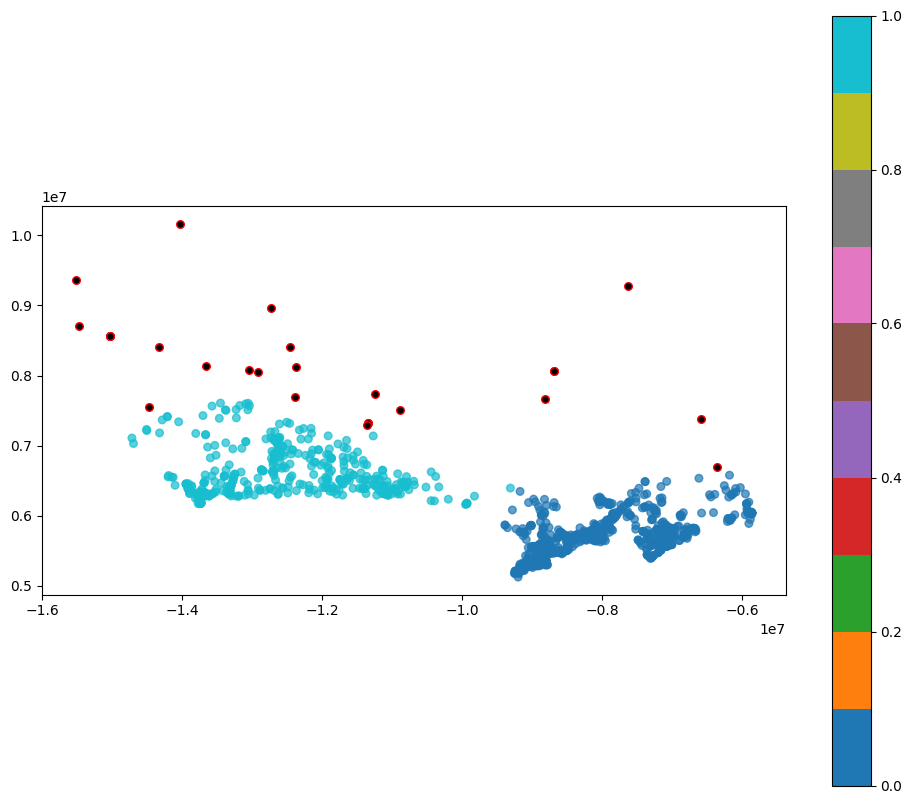

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# STEP 1: Load the dataset
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding="ISO-8859-1")

# STEP 2: Filter only museum entries
df = df[df['ODCAF_Facility_Type'].str.strip().str.lower() == 'museum']

# STEP 3: Drop missing or invalid coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude'])

# STEP 4: Prepare coordinates and scale
coords = df[['Latitude', 'Longitude']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# STEP 5: Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
df['Cluster'] = dbscan.fit_predict(coords_scaled)

# STEP 6: Plot on basemap
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
        crs="EPSG:4326"
    )
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 10))
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]

    # Plot noise in red
    if not noise.empty:
        noise.plot(ax=ax, color='k', markersize=30, ec='r', label='Noise')

    # Plot clusters
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, legend=True, alpha=0.7)

    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=4)
    ax.set_axis_off()
    plt.title(title, fontsize=15)
    plt.show()

# Run the plot
plot_clustered_locations(df, title="Museums Clustered using DBSCAN")


- What do you see?
- What size is the smallest cluster?
- Do you think the clusters make sense in terms of what you expect to see?
- Do you think there should be more clusters in some regions? Why?


One key thing to notice here is that the clusters are not uniformly dense.

For example, the points are quite densely packed in a few regions but are relatively sparse in between.

DBSCAN agglomerates neighboring clusters together when they are close enough.

Let's see how a hierarchical density-based clustering algorithm like HDBSCAN performs.


## Build an HDBSCAN clustering model
At this stage, you've already loaded your data and extracted the museum coordinates into a dataframe, df.

You've also stored properly scaled coordinates as the 'coords_scaled' array.

All that remains is to:
- Fit and transform HDBSCAN to your scaled coordinates
- Extract the cluster labels
- Plot the results on the same basemap as before

Reasonable HDBSCAN parameters have been selected for you to start with.


#### Initialize an HDBSCAN model


In [39]:
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')  # You can adjust parameters as needed

### Exercise 6. Assign the cluster labels to your unscaled coordinate dataframe and display the counts of each cluster label.


In [40]:
# Exercise 6 - Assign HDBSCAN cluster labels
df['Cluster'] = hdb.fit_predict(coords)

# Display the size of each cluster
print("Cluster distribution:")
print(df['Cluster'].value_counts())


Cluster distribution:
Cluster
-1      469
 139     51
 88      39
 72      36
 71      28
       ... 
 60       3
 55       3
 73       3
 126      3
 125      3
Name: count, Length: 141, dtype: int64


<details><summary>Click here for the solution</summary>

```python
# Assign labels
df['Cluster'] = hdb.fit_predict(coords_scaled)  # Another way to assign the labels

# Display the size of each cluster
df['Cluster'].value_counts()
```


As you can see, unlike the case for DBSCAN, clusters quite uniformly sized, although there is a quite lot of noise identified.
### Exercise 7. Plot the hierarchically clustered museums on a basemap of Canada, colored by cluster label.


In [ ]:
# Exercise 7 - Plot hierarchical clusters
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity (HDBSCAN)')


<details><summary>Click here for the solution</summary>
    
```python
# Plot the museum clusters
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')
```


### Closing remarks


Take a close look at the map.
- What's different about these results compared to DBSCAN?
- It might seem like there are more points identified as noise, but is that the case?
- Can you see the variations in density that HDBSCAN captures?
- In practice, you would want to investigate much deeper but at least you get the idea here.


## Summary
Congratulations! You're ready to move on to your next lesson! In this lab, you learned how to implement DBSCAN and HDBSCAN clustering models using scikit-learn on real data from StatCan, focusing on museum locations across Canada. You also compared the performance of the two clustering techniques.

## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>


### Other Contributors

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>


<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-05 | 1.0  | Jeff Grossman    | Update content and practice exercises |
 -->


## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>


